# Stock prices prediction

In this notebook, we'll compare different methods to predict stock prices. Methods for time series forecasting are not only used in finance, they are everywhere. Check this excellent [video](https://www.youtube.com/watch?v=JntA9XaTebs&t=2s) for examples of applications.

The aim is to study two approaches:

* statistical 
* machine learning 

Data are from Quandl API, a financial data provider.

In [1]:
# iconic trio for data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from config import get_quandl_api_key

%matplotlib inline

# python module for quandl, a financial data provider
import quandl

# statistics module
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = [30,15]
plt.rcParams['font.size'] = 22

In [2]:
# set up a client to the Quandl API
quandl_api_key = get_quandl_api_key()
quandl.ApiConfig.api_key = quandl_api_key
quandl_code = "EOD/NKE" # code for the Nike Inc. (New York Stock Exchange)

# get the data 
nike_data = quandl.get(quandl_code)

In [3]:
nike_data.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
1980-12-02,11.50,11.75,11.50,11.50,786800.0,0.0,1.0,0.060487,0.061802,0.060487,0.060487,100710400.0
1980-12-03,11.38,11.38,11.25,11.25,196700.0,0.0,1.0,0.059856,0.059856,0.059172,0.059172,25177600.0
1980-12-04,11.62,11.75,11.62,11.62,177300.0,0.0,1.0,0.061118,0.061802,0.061118,0.061118,22694400.0
1980-12-05,11.25,11.25,11.00,11.00,59300.0,0.0,1.0,0.059172,0.059172,0.057857,0.057857,7590400.0
1980-12-08,10.50,10.50,10.38,10.38,42300.0,0.0,1.0,0.055227,0.055227,0.054596,0.054596,5414400.0


More info on the data we use right [here](https://www.quandl.com/data/EOD/NKE-Nike-Inc-NKE-Stock-Prices-Dividends-and-Splits). For our purpose, we are going to only use the 'Close' column since it is heavily correlated with other columns and we have to choose one among them.
We are lucky to have more than 30 years of historical data of good quality.

In [4]:
stock_price = nike_data['Close']
stock_price.describe()

count    9620.000000
mean       55.669589
std        27.152826
min         6.870000
25%        39.587500
50%        56.500000
75%        74.752500
max       134.330000
Name: Close, dtype: float64

So we have more than 9620 data points. On average the stock price is about 55 dollars.

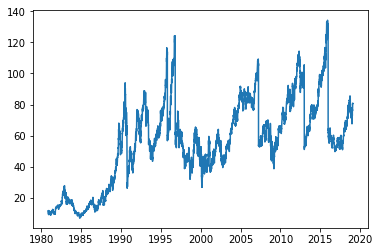

In [5]:
sns.lineplot(data = stock_price, markers = True)

## Statistics
There are several statistical approches to model time series and predict the future.
Before applying a model, we need to study the data we have. We compute several metrics.

In [6]:
decomposition = sm.tsa.seasonal_decompose(stock_price, model='additive', freq=300)


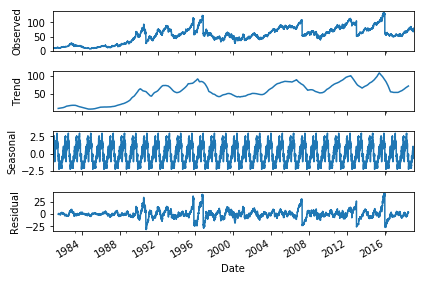

In [7]:
fig = decomposition.plot()

Then, most of the models are made on the assumption of stationarity.
A time series is said stationay if:
* the mean remains constant over time
* the variance too
* the autocovariance does not depend on the time

To verify the stationarity, we can use a statistical test. A good one is the Dickey Fuller test.

### The Dickey Fuller test

The Dickey-Fuller test is part of the statistical toolkit of **hypothesis testing**. A **statistical hypothesis test** is a method of statistical inference. It allows us to better know the properties of the data set we have and is commonly used in data science / analysis.

Basically, we make two hypotheses:
* the **null hypothesis**. Ex: means of two samples are equals, random variables are independant, the distribution is normal, the time series is stationary ...
* the **alternate hypothesis**. Ex: means of two samples are different, there exists a relationship between random variables, the distribution is not normal, the time series is not stationary ...

The two are compared and the aim is to determine if we **reject** or **accept** the null hypothesis. Note that the hypotheses are imposed by the test. We also define a threshold $\alpha$, commonly set to 0.05 or 0.01. We compare the value obtained with this **significance level** to conclude. 
There are lots of statistical tests. For example:
- [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test)
- [Z-test](https://en.wikipedia.org/wiki/Z-test)
- [Shapiro test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test)

Fortunately, we don't have to code a statistical test ourself and we can use functions already well coded and tested by the open source community.

In [8]:
sm.tsa.stattools.adfuller(stock_price)

(-3.2378834674536665,
 0.01789392388571921,
 2,
 9617,
 {'1%': -3.431030154550236,
  '5%': -2.861840586533739,
  '10%': -2.566929997097528},
 38306.765920186604)

From the documentation, here is the format of what the function returns:
* adf : float
    Test statistic
* pvalue : float
    MacKinnon's approximate p-value based on MacKinnon (1994, 2010)
* usedlag : int
    Number of lags used
* nobs : int
    Number of observations used for the ADF regression and calculation of
    the critical values
* critical values : dict
    Critical values for the test statistic at the 1 %, 5 %, and 10 %
    levels. Based on MacKinnon (2010)
* icbest : float
    The maximized information criterion if autolag is not None.
* resstore : ResultStore, optional
    A dummy class with results attached as attributes
    
So our test statistic is out of the acceptation interval and the p-value is less than the risk of 5 %, so we reject the null hypothesis. Our time series is not stationary.